In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import dblquad


In [42]:

# Function to calculate the NFW halo density profile
def nfw_halo(r, rs):
    x = r / rs
    return rhos / (x * (1 + x)**2)


In [43]:


# Function to calculate the Milky Way density profile based on Gondolo-Silk model
def mw_density_GS(r, Rs, Rsat, Rsp, gamma_sp,rho_sat):
    density = np.zeros_like(r)


    # Condition 1: r < 2RS
    mask_condition_1 = r < 2 * Rs
    density[mask_condition_1] = 0

    # Condition 2: 2RS ≤ r < Rsat
    mask_condition_2 = (r >= 2 * Rs) & (r < Rsat)
    density[mask_condition_2] = rho_sat * (r[mask_condition_2] / Rsat)**(-0.5)

    # Condition 3: Rsat ≤ r < Rsp
    mask_condition_3 = (r >= Rsat) & (r < Rsp)
    x = r[mask_condition_3] / Rsp
    density[mask_condition_3] = nfw_halo(Rsp, rs) * x**(-gamma_sp)

    # Condition 4: r ≥ Rsp
    mask_condition_4 = r >= Rsp
    density[mask_condition_4] = nfw_halo(r[mask_condition_4], rs)

    return density



In [84]:


# Constants and parameters
rs = 18.6  # Scale radius in kpc
rho0 = 0.383  # Local DM density in GeV/cm^3
r0 = 8.2  # Sun position in kpc
m_chi = 1000# Dark matter mass in GeV
t = 3.15 * 10**17  # in s
rhos = (rho0 * ((r0 / rs) * (1 + r0 / rs)**(2)))
R = 200
# Parameters for the Milky Way density profile
Rs = 3.8 * 10**(-11)  # Example value for Rs
Rsp = 0.34 * 10**(-3)  # Example value for Rsp
gamma_sp = 2.35  # Example value for gamma_sp



In [86]:
sigma_v =  np.logspace(-33,-18, 100)
rho_sat = []
R_sat = []

# Calculating rho_sat and R_sat
for i in range(len(sigma_v)):
    rh = m_chi / (sigma_v[i] * t)
    rho_sat.append(rh) 
    r_sat = (((rhos / rh) * (rs / Rsp) * ((1 + (Rsp / rs))**(-2)))**(1 / gamma_sp)) * Rsp
    R_sat.append(r_sat)

In [91]:
def radial(l,theta):
    return np.sqrt(l**2 + r0**2 - 2 * l * r0 * np.cos(theta))


In [105]:
J = []
for i in range(len(sigma_v)):
    integrand = lambda l, theta: mw_density_GS(np.sqrt(l**2 + r0**2 - 2 * l * r0 * np.cos(theta)), Rs, R_sat[i], Rsp, gamma_sp, rho_sat[i])**2 * np.sin(theta) * 2 * np.pi
    integral, error = dblquad(integrand, 0, np.pi, lambda theta: 0, lambda theta: np.sqrt(R**2 - r0**2 * np.sin(theta)**2) + r0 * np.cos(theta))
    print(integral)
    J.append(integral)

46.02934987022881
46.02934987022881


KeyboardInterrupt: 

In [ ]:
for theta in np.linspace(0, np.pi, 10):
    for l in np.linspace(0, 10, 10):  # Adjust the range of l as needed
        r_value = np.sqrt(l**2 + r0**2 - 2 * l * r0 * np.cos(theta))
        print("For l =", l, "and theta =", theta, ", r =", r_value)
        density = mw_density_GS(r_value, Rs, R_sat[0], Rsp, gamma_sp, rho_sat[0])
        print("Density at r_value =", r_value, ":", density)

In [ ]:
# Calculate J factors
plt.plot(sigma_v, J,label='GS', color='b')
plt.xlabel('Radius (r in kpc)')
plt.ylabel('Density (rho in GeV/cm^3)')
plt.title('Milky Way DM Density Profile')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

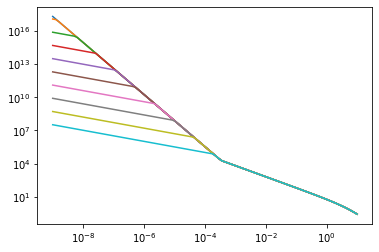

In [90]:

for i in range(0,len(sigma_v),10):
    plt.plot(r,mw_density_GS(radial(l,theta),Rs,R_sat[i],Rsp,gamma_sp,rho_sat[i]))
plt.yscale('log')
plt.xscale('log')